### Libraries

In [ ]:
# Load Libraries
import os
import numpy as np
import pandas as pd 
import cv2
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.applications import vgg16
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.models import Sequential
%matplotlib inline

### Preprocessing
1. Import data
2. Label data
3. Split data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load images
def load_im():
    input_im, input_label = [], []
    resize = (224, 224)
    # Loop in folders
    for dirname, _, filenames in os.walk('drive/MyDrive/proj dataset/archive'):
        for filename in filenames:
            photo_path = os.path.join(dirname, filename)
            photo_class = dirname.split('/')[-1]
            try:
                read_im = cv2.imread(photo_path)
                input_im.append(cv2.resize(read_im, resize))
                # potholes == 1
                if photo_class == 'potholes':
                    input_label.append(1)
                # normal == 0
                elif photo_class == 'normal':
                    input_label.append(0)
            except:
                print(photo_path)
    # return list of images and another list of correponding labels
    return input_im, input_label

input_im, input_label = load_im()

drive/MyDrive/proj dataset/archive/normal/226.jpg


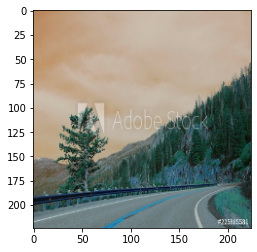

0


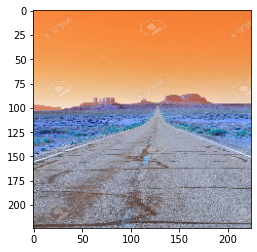

0


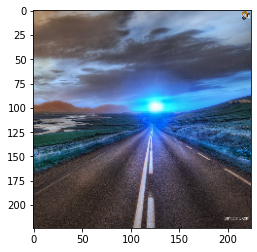

0


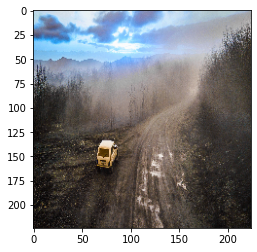

0


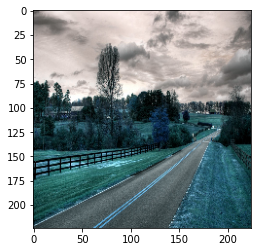

0


In [ ]:
# Checking code: Print photo and class
index_set = np.random.choice(len(input_label), size = 5, replace = False)
for index in index_set:
    # show images
    plt.imshow(input_im[index])
    plt.show()
    # show label
    print(input_label[index])

### Image augmentation
Applied to training set only
1. Horizontal Flipping
2. Clockwise and Anti-clockwise Rotation by 30 degree

In [ ]:
# Train/Test split
def train_test_split(test_prop, input_im, input_label):
    # Random sampling of index
    test_size = int(np.floor(test_prop * len(input_label)))
    test_index = np.random.choice(len(input_label), size = test_size, replace = False)
    # Split
    train_x, test_x, train_y, test_y = np.delete(input_im, test_index, axis = 0), np.take(input_im, test_index, axis = 0), np.delete(input_label, test_index, axis = 0), np.take(input_label, test_index, axis = 0)
    # Return train and test sets for both images and labels
    return train_x, test_x, train_y, test_y, test_index

# 80/20 split for small data set
test_prop = 0.2
train_x, test_x, train_y, test_y, test_index = train_test_split(test_prop, input_im, input_label)

In [ ]:
def append_im(input_im, input_label, im_iterator):
    input_label_n = input_label.copy()
    input_im_n = input_im.copy()
    for i in range(len(im_iterator)):
        im = im_iterator[i]
        im = im.astype('uint8')
        im_lbl = [input_label[i]]
        input_im_n = np.append(input_im_n, im, axis = 0)
        input_label_n = np.append(input_label_n, im_lbl, axis = 0)
    return input_im_n, input_label_n

In [ ]:
# Flipping
flip_data_generator = ImageDataGenerator(horizontal_flip = True)
im_iterator = flip_data_generator.flow(train_x, batch_size = 1, shuffle = False)
input_im_n, input_label_n = append_im(train_x, train_y, im_iterator)

# Rotation - 30 deg 
#rotate_data_generartor = ImageDataGenerator(rotation_range = 30)
#im_iterator = rotate_data_generartor.flow(train_x, batch_size = 1, shuffle = False)
#input_im_n, input_label_n = append_im(input_im_n, input_label_n, im_iterator)

# Rotation - -30 deg 
#rotate_data_generartor = ImageDataGenerator(rotation_range = 330)
#im_iterator = rotate_data_generartor.flow(train_x, batch_size = 1, shuffle = False)
#input_im_n, input_label_n = append_im(input_im_n, input_label_n, im_iterator)

In [ ]:
# Reshape
nx, ny, nz = train_x.shape[1], train_x.shape[2], train_x.shape[3]
train_x_nn, test_x_nn = input_im_n, test_x
train_x = input_im_n.reshape((input_im_n.shape[0], nx * ny * nz)) / 255
test_x = test_x.reshape((test_x.shape[0], nx * ny * nz)) / 255
train_y = input_label_n.reshape((input_label_n.shape[0], 1)) 
test_y = test_y.reshape((test_y.shape[0], 1)) 

 ### Dimensionality Reduction
Since images are of high resolution, input matrix has a high column dimension. So, dimensionality reduction may be useful in this situation. Principal component analysis (PCA) will be employed.

In [ ]:
# Dimensionality reduction - Full PCA
im_pca = PCA()
im_pca.fit(train_x)
variance_explained_list = im_pca.explained_variance_ratio_.cumsum()
print(variance_explained_list)

[0.19670282 0.31403048 0.37012965 ... 1.         1.         1.        ]


In [ ]:
test_x_pca = im_pca.transform(test_x)
train_x_pca = im_pca.transform(train_x)

### Machine learning models
1. Support vector machine (SVM) - PCA-SVM
2. Logistic regression - Baseline Model
3. Convolutional neural network (CNN)

In [ ]:
# Support vector machine with PCA
def svm_grid_search(C, kernel, train_x, train_y):
    accuracy_score_list = []
    
    for c in C:
        # Model training
        svmClassifier = svm.SVC(C = c, kernel = kernel)
        svmClassifier.fit(train_x, train_y.ravel())
        # Prediction on test set
        pred_y = svmClassifier.predict(train_x)
        # Accuracy
        accuracy = accuracy_score(train_y, pred_y)
        accuracy_score_list.append(accuracy)
        print('Regularization parameters: ', c, 'Accuracy', accuracy)
    
    max_accurarcy_id = accuracy_score_list.index(max(accuracy_score_list))
    return C[max_accurarcy_id] 

topt_C = svm_grid_search(C, kernel, train_x_pca, train_y)

Regularization parameters:  0.1 Accuracy 0.8253676470588235
Regularization parameters:  0.2 Accuracy 0.8915441176470589
Regularization parameters:  0.30000000000000004 Accuracy 0.9181985294117647
Regularization parameters:  0.4 Accuracy 0.9319852941176471
Regularization parameters:  0.5 Accuracy 0.9503676470588235
Regularization parameters:  0.6000000000000001 Accuracy 0.9568014705882353
Regularization parameters:  0.7000000000000001 Accuracy 0.9641544117647058
Regularization parameters:  0.8 Accuracy 0.9696691176470589
Regularization parameters:  0.9 Accuracy 0.9770220588235294
Regularization parameters:  1.0 Accuracy 0.9779411764705882
Regularization parameters:  1.1 Accuracy 0.9806985294117647
Regularization parameters:  1.2000000000000002 Accuracy 0.9862132352941176
Regularization parameters:  1.3 Accuracy 0.9898897058823529
Regularization parameters:  1.4000000000000001 Accuracy 0.9935661764705882
Regularization parameters:  1.5 Accuracy 0.9944852941176471
Regularization parameter

In [ ]:
# Test set
svmClassifier = svm.SVC(C = opt_C, kernel = kernel)
svmClassifier.fit(train_x_pca, train_y.ravel())
pred_y = svmClassifier.predict(test_x_pca)
accuracy = accuracy_score(test_y, pred_y)
print(accuracy)

0.8602941176470589


In [ ]:
def predict_img(svmClassifier,test_x,test_y):
  pred_y = svmClassifier.predict(test_x)
  accuracy = accuracy_score(test_y, pred_y)
  print(accuracy)
  for index in range(len(test_y)):
    print("Image :" , index+1)
    plt.imshow(test_x_nn[index])
    plt.show()
    if test_y[index]==1:
      print("Actual: Image contains potholes")
    else:
      print("Actual: Image does not contain potholes")
      
    if pred_y[index]==1:
      print("Predicted: Image contains potholes")
    else:
      print("Predicted: Image does not contain potholes")

predict_img(svmClassifier,test_x_pca,test_y)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
from google.colab.patches import cv2_imshow
def mark_pothole(svmClassifier,test_x,test_y):
  pred_y = svmClassifier.predict(test_x)
  accuracy = accuracy_score(test_y, pred_y)
  print(accuracy)
  for index in range(len(test_y)):
    img=input_im[test_index[index]]
    #print(img)
    print("Image :" , index+1)
    plt.imshow(img)
    plt.show()
    if test_y[index]==1:
      print("Actual: Image contains potholes")
    else:
      print("Actual: Image does not contain potholes")
      
    if pred_y[index]==1:
      print("Predicted: Image contains potholes")
      img = input_im[test_index[index]]
      img=cv2.resize(img, (500, 500))
      #Converting the image to grayscale
      gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
      #Finding the edges in the image using Canny edge detection
      edges = cv2.Canny(gray,50,150,apertureSize = 3)#Finding the contours in the image
      contours,hierarchy = cv2.findContours(edges, 1, 2)
      #Looping throught the contours
      for cnt in contours:
        #Creating a rectangle around the contours
        x,y,w,h = cv2.boundingRect(cnt)
        width_relative = img.shape[0]/w
        height_relative = img.shape[1]/h
        #Checking if the size of the hole is greater than the specified size
        if w>100 and h>100:
          #if width_relative > 1 and height_relative > 1:
          #Drawing the rectangle
          cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
        #Displaying the output image
      #cv2_imshow(edges)
      cv2_imshow(img)
      cv2.waitKey(0)
      cv2.destroyAllWindows()

mark_pothole(svmClassifier,test_x_pca,test_y)


Output hidden; open in https://colab.research.google.com to view.

### SVM with PCA performance
**Model parameters:**

Regularization parameters = 2.9

Kernel = Radial Basis Function


**Test set accuracy: 86.02%**

Decision tree


In [ ]:
# Logistic Regression
def Logistic():
    logistic_model = Sequential()
    logistic_model.add(Dense(1, activation = 'sigmoid'))
    return logistic_model

# Compile Model
logistic_model = Logistic()
logistic_model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [ ]:
# Training Model
logistic_model.fit(train_x, train_y, batch_size = 32, epochs = 50, verbose = 1)

Epoch 1/50
34/34 [==============================] - 2s 20ms/step - loss: 5.6959 - accuracy: 0.5763
Epoch 2/50
34/34 [==============================] - 0s 15ms/step - loss: 0.8745 - accuracy: 0.7803
Epoch 3/50
34/34 [==============================] - 0s 13ms/step - loss: 0.9697 - accuracy: 0.7500
Epoch 4/50
34/34 [==============================] - 0s 14ms/step - loss: 1.2080 - accuracy: 0.7316
Epoch 5/50
34/34 [==============================] - 1s 14ms/step - loss: 1.5445 - accuracy: 0.7344
Epoch 6/50
34/34 [==============================] - 0s 14ms/step - loss: 0.8025 - accuracy: 0.8272
Epoch 7/50
34/34 [==============================] - 0s 14ms/step - loss: 1.0794 - accuracy: 0.7647
Epoch 8/50
34/34 [==============================] - 0s 14ms/step - loss: 0.7597 - accuracy: 0.8447
Epoch 9/50
34/34 [==============================] - 0s 14ms/step - loss: 0.2427 - accuracy: 0.9182
Epoch 10/50
34/34 [==============================] - 0s 14ms/step - loss: 0.2185 - accuracy: 0.9320
Epoch 11/

In [ ]:
# Test set
print(logistic_model.metrics_names)
print(logistic_model.evaluate(test_x, test_y, verbose = 0))

['loss', 'accuracy']
[2.1870110034942627, 0.779411792755127]


In [ ]:
# Predicting on the test set
predictions = logistic_model.predict(test_x)
print(len(predictions),len(test_y))
for i in range(len(predictions)):
  img = input_im[test_index[i]]
  img=cv2.resize(img, (500, 500))

  if predictions[i] > 0.5:
      print("Image contains pothole")
      gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
      #Finding the edges in the image using Canny edge detection
      edges = cv2.Canny(gray,50,150,apertureSize = 3)#Finding the contours in the image
      contours,hierarchy = cv2.findContours(edges, 1, 2)
      #Looping throught the contours
      for cnt in contours:
        #Creating a rectangle around the contours
        x,y,w,h = cv2.boundingRect(cnt)
        width_relative = img.shape[0]/w
        height_relative = img.shape[1]/h
        #Checking if the size of the hole is greater than the specified size
        if w>100 and h>100:
          #if width_relative > 1 and height_relative > 1:
          #Drawing the rectangle
          cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
  else:
      print("Image does not contain pothole")
  cv2_imshow(img)
  cv2.waitKey(0)
  cv2.destroyAllWindows()

Output hidden; open in https://colab.research.google.com to view.

### Logistic Classifier Performance
**Test set accuracy: 81.6%**

In [ ]:
# Convolutional Neural Network 
def CNN():
    CNN_model = Sequential()
    
    CNN_model.add(Conv2D(filters = 96, input_shape = (224, 224, 3), kernel_size = (11, 11), strides = (4, 4), padding = 'valid'))
    CNN_model.add(Activation('relu'))
    CNN_model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'valid'))
    
    CNN_model.add(Conv2D(filters = 256,  kernel_size = (5, 5), strides = (1, 1), padding = 'valid'))
    CNN_model.add(Activation('relu'))
    CNN_model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2), padding = 'valid'))
    
    CNN_model.add(Flatten())
    CNN_model.add(Dense(512))
    CNN_model.add(Activation('relu'))
    
    CNN_model.add(Dense(256))
    CNN_model.add(Activation('relu'))
    
    CNN_model.add(Dense(1, activation = 'sigmoid'))
    
    return CNN_model

# Compile Model
cnn_model = CNN()
cnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 


In [ ]:
# Training Model
cnn_model.fit(train_x_nn/255, train_y, batch_size = 256, epochs = 50, verbose = 1)

Epoch 1/50
5/5 [==============================] - 70s 13s/step - loss: 1.5895 - accuracy: 0.4963
Epoch 2/50
5/5 [==============================] - 64s 12s/step - loss: 0.6952 - accuracy: 0.5404
Epoch 3/50
5/5 [==============================] - 75s 15s/step - loss: 0.6713 - accuracy: 0.5855
Epoch 4/50
5/5 [==============================] - 66s 13s/step - loss: 0.5843 - accuracy: 0.7132
Epoch 5/50
5/5 [==============================] - 63s 12s/step - loss: 0.5530 - accuracy: 0.7243
Epoch 6/50
5/5 [==============================] - 65s 12s/step - loss: 0.4929 - accuracy: 0.7693
Epoch 7/50
5/5 [==============================] - 74s 15s/step - loss: 0.4208 - accuracy: 0.8336
Epoch 8/50
5/5 [==============================] - 66s 12s/step - loss: 0.3959 - accuracy: 0.8254
Epoch 9/50


KeyboardInterrupt: ignored

In [ ]:
print(cnn_model.metrics_names)
print(cnn_model.evaluate(test_x_nn/255, test_y, verbose = 0))

### CNN Performance
**Test set accuracy: 85.3%**

### Summary
**Test set accuracy: PCA + SVM > CNN > Logistic classifier**

To improve performance, we can use a pretrained network / uncomment the remaining image augmentation (rotation) codes / scrape more data on the website.